### Import the Libraries

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

### Import the Dataset

In [2]:
df = pd.read_csv(r'RFM data.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


### Q1 Calculate 
    a) recency (R),
    b)  frequency (F)
    c)  monetary value (M)
    for each customer based on the given dataset?

In [3]:
# Convert 'InvoiceDate' to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [4]:
# Calculate Recency (days since last purchase)
recency_df = df.groupby(by='CustomerID', as_index=False)['InvoiceDate'].max()
recency_df.head()

,CustomerID,InvoiceDate
0,12347.0,2011-12-07 15:52:00
1,12348.0,2011-09-25 13:13:00
2,12349.0,2011-11-21 09:51:00
3,12350.0,2011-02-02 16:01:00
4,12352.0,2011-11-03 14:37:00


In [5]:
recency_df.columns = ['CustomerID','LastPurchaseDate']
recency_df.head()

,CustomerID,LastPurchaseDate
0,12347.0,2011-12-07 15:52:00
1,12348.0,2011-09-25 13:13:00
2,12349.0,2011-11-21 09:51:00
3,12350.0,2011-02-02 16:01:00
4,12352.0,2011-11-03 14:37:00


In [6]:
recent_date = recency_df['LastPurchaseDate'].max()
recent_date

Timestamp('2011-12-09 12:50:00')

In [7]:
recency_df['Recency']=recency_df['LastPurchaseDate'].apply(lambda x: (recent_date-x).days)
recency_df.head()

,CustomerID,LastPurchaseDate,Recency
0,12347.0,2011-12-07 15:52:00,1
1,12348.0,2011-09-25 13:13:00,74
2,12349.0,2011-11-21 09:51:00,18
3,12350.0,2011-02-02 16:01:00,309
4,12352.0,2011-11-03 14:37:00,35


In [8]:
recency_df.drop(columns='LastPurchaseDate',inplace=True)
recency_df

,CustomerID,Recency
0,12347.0,1
1,12348.0,74
2,12349.0,18
3,12350.0,309
4,12352.0,35
...,...,...
4293,18280.0,277
4294,18281.0,180
4295,18282.0,7
4296,18283.0,3


In [9]:
# Calculate Frequency (number of purchases)
frequency_df = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
frequency_df.columns = ['CustomerID', 'Frequency']
frequency_df

,CustomerID,Frequency
0,12347.0,7
1,12348.0,4
2,12349.0,1
3,12350.0,1
4,12352.0,7
...,...,...
4293,18280.0,1
4294,18281.0,1
4295,18282.0,2
4296,18283.0,16


In [10]:
# Calculate Monetary Value (total amount spent)
monetary_df = df.groupby('CustomerID')['TotalPrice'].sum().reset_index()
monetary_df.columns = ['CustomerID', 'Monetary']
monetary_df

,CustomerID,Monetary
0,12347.0,4060.40
1,12348.0,1437.24
2,12349.0,1417.60
3,12350.0,294.40
4,12352.0,1385.74
...,...,...
4293,18280.0,180.60
4294,18281.0,80.82
4295,18282.0,178.05
4296,18283.0,2088.93


In [11]:
# Merge Recency, Frequency, and Monetary DataFrames
rf_df = pd.merge(recency_df, frequency_df, on='CustomerID')
rfm_df = pd.merge(rf_df, monetary_df, on='CustomerID')

print(rfm_df)

      CustomerID  Recency  Frequency  Monetary
0        12347.0        1          7   4060.40
1        12348.0       74          4   1437.24
2        12349.0       18          1   1417.60
3        12350.0      309          1    294.40
4        12352.0       35          7   1385.74
...          ...      ...        ...       ...
4293     18280.0      277          1    180.60
4294     18281.0      180          1     80.82
4295     18282.0        7          2    178.05
4296     18283.0        3         16   2088.93
4297     18287.0       42          3   1837.28

[4298 rows x 4 columns]


### Q2 a) Calculate RFM scores.
    Each customer will get a note between 1 and 5 for each parameter for Recency(R), Frequency(F) and Monetary value(M)
    Ex: Scale for Recency:
    1: 0-30 days
    2: 31-60 days
    3: 61-90 days
    4: 91-180 days
    5: 181-365 days

In [12]:
# Define function to assign scores based on provided scale
def assign_score(value, scale):
    for score, interval in scale.items():
        if value >= interval[0] and value <= interval[1]:
            return score
    return None  # Return None if value doesn't fall into any interval

In [13]:
# Define scale for Recency, Frequency, and Monetary
recency_scale = {1: (0, 30), 2: (31, 60), 3: (61, 90), 4: (91, 180), 5: (181, 365)}
frequency_monetary_scale = {1: (0, 2), 2: (3, 4), 3: (5, 7), 4: (8, 10), 5: (11, float('inf'))}

In [14]:
# Calculate RFM scores
rfm_df['RecencyScore'] = rfm_df['Recency'].apply(lambda x: assign_score(x, recency_scale))
rfm_df['FrequencyScore'] = rfm_df['Frequency'].apply(lambda x: assign_score(x, frequency_monetary_scale))
rfm_df['MonetaryScore'] = rfm_df['Monetary'].apply(lambda x: assign_score(x, frequency_monetary_scale))

print(rfm_df)

      CustomerID  Recency  Frequency  Monetary  RecencyScore  FrequencyScore  \
0        12347.0        1          7   4060.40           1.0               3   
1        12348.0       74          4   1437.24           3.0               2   
2        12349.0       18          1   1417.60           1.0               1   
3        12350.0      309          1    294.40           5.0               1   
4        12352.0       35          7   1385.74           2.0               3   
...          ...      ...        ...       ...           ...             ...   
4293     18280.0      277          1    180.60           5.0               1   
4294     18281.0      180          1     80.82           4.0               1   
4295     18282.0        7          2    178.05           1.0               1   
4296     18283.0        3         16   2088.93           1.0               5   
4297     18287.0       42          3   1837.28           2.0               2   

      MonetaryScore  
0               5

### b) Segment the customers based on their RFM scores using the dataset?

Segments with RFM score range:

- Champions: RFM score range - R: 4-5, F: 4-5, M: 4-5
- Loyal customers: RFM score range - R: 3-5, F: 3-5, M: 3-5
- Potential loyalist: RFM score range - R: 4-5, F: 2-3, M: 2-3
- Recent customers: RFM score range - R: 4-5, F: 1-2, M: 1-2
- Promising: RFM score range - R: 4-5, F: 1-2, M: 1-2
- Needs attention: RFM score range - R: 3-5, F: 3-5, M: 3-5
- About to sleep: RFM score range - R: 1-2, F: 1-2, M: 1-2
- At risk: RFM score range - R: 2-5, F: 1-3, M: 1-3
- Can't lose them: RFM score range - R: 1-3, F: 4-5, M: 4-5
- Hibernating: RFM score range - R: 1-2, F: 1-2, M: 1-2



In [15]:
# Define function to assign segments based on RFM scores
def assign_segment(row):
    r_score = row['RecencyScore']
    f_score = row['FrequencyScore']
    m_score = row['MonetaryScore']
    
    if r_score in [4, 5] and f_score in [4, 5] and m_score in [4, 5]:
        return 'Champions'
    elif r_score in [3, 5] and f_score in [3, 5] and m_score in [3, 5]:
        return 'Loyal customers'
    elif r_score in [4, 5] and f_score in [2, 3] and m_score in [2, 3]:
        return 'Potential loyalist'
    elif r_score in [4, 5] and f_score in [1, 2] and m_score in [1, 2]:
        return 'Recent customers'
    elif r_score in [4, 5] and f_score in [1, 2] and m_score in [1, 2]:
        return 'Promising'
    elif r_score in [3, 5] and f_score in [3, 5] and m_score in [3, 5]:
        return 'Needs attention'
    elif r_score in [1, 2] and f_score in [1, 2] and m_score in [1, 2]:
        return 'About to sleep'
    elif r_score in [2, 5] and f_score in [1, 3] and m_score in [1, 3]:
        return 'At risk'
    elif r_score in [1, 3] and f_score in [4, 5] and m_score in [4, 5]:
        return "Can't lose them"
    elif r_score in [1, 2] and f_score in [1, 2] and m_score in [1, 2]:
        return 'Hibernating'
    else:
        return 'Other'

# Assign segments to customers
rfm_df['Segment'] = rfm_df.apply(assign_segment, axis=1)

print(rfm_df)

      CustomerID  Recency  Frequency  Monetary  RecencyScore  FrequencyScore  \
0        12347.0        1          7   4060.40           1.0               3   
1        12348.0       74          4   1437.24           3.0               2   
2        12349.0       18          1   1417.60           1.0               1   
3        12350.0      309          1    294.40           5.0               1   
4        12352.0       35          7   1385.74           2.0               3   
...          ...      ...        ...       ...           ...             ...   
4293     18280.0      277          1    180.60           5.0               1   
4294     18281.0      180          1     80.82           4.0               1   
4295     18282.0        7          2    178.05           1.0               1   
4296     18283.0        3         16   2088.93           1.0               5   
4297     18287.0       42          3   1837.28           2.0               2   

      MonetaryScore          Segment  


In [16]:
rfm_df['Segment'].value_counts()

Segment
Other               3748
Can't lose them      468
Loyal customers       64
Champions             17
Recent customers       1
Name: count, dtype: int64

### Q3 a) Visualize the RFM segments.

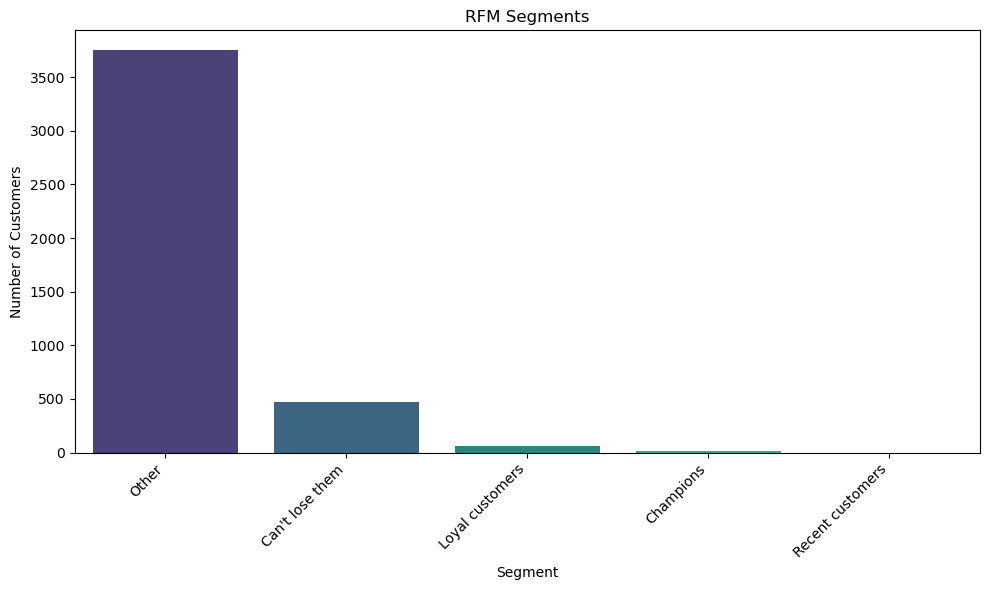

In [17]:
# Count the number of customers in each segment
segment_counts = rfm_df['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Count']

# Plot the RFM segments
plt.figure(figsize=(10, 6))
sns.barplot(x='Segment', y='Count', data=segment_counts, palette='viridis')
plt.title('RFM Segments')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### b) Conclude your findings of RFM analysis and suggest some strategies on it.

Can't Lose Them: Implement personalized rewards, exclusive perks, and proactive retention campaigns to maintain engagement and                  prevent churn among these valuable customers.

Champions: Reward loyal customers with exclusive offers and maintain engagement.

Loyal Customers: Continue nurturing relationships and provide personalized services to maintain loyalty.

Recent Customers: Welcome new customers with personalized communications and incentives for repeat purchases.